# Environment Initialization

In [ ]:
%%capture
!rm -rf /tools/node/*
!wget -c https://nodejs.org/dist/v10.20.1/node-v10.20.1-linux-x64.tar.xz
!sudo tar --overwrite -xJvf node-v10.20.1-linux-x64.tar.xz
!cp -r node-v10.20.1-linux-x64/* /tools/node/ && rm -rf node-v10*
!pip install tensorflowjs

In [ ]:
%%capture 
!pip install git+https://github.com/Kings-Distributed-Systems/Bifrost.git

In [ ]:
%%capture
!git clone https://github.com/Kings-Distributed-Systems/tfjs_util.git
!cd tfjs_util && npm i && npm run postinstall

In [ ]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflowjs as tfjs
from bifrost import node, npm
from google.colab import files

# Training and building VAE

Please do not run the following cells.


In [ ]:
(_xtrain, _ytrain), (_xtest, _ytest) = tf.keras.datasets.mnist.load_data()
_xtrain = _xtrain.astype(np.float32) / 255.
_xtest  = _xtest.astype(np.float32)  / 255.
if len(_xtrain.shape) < 4:
    _xtrain = np.expand_dims(_xtrain,-1)
    _xtest = np.expand_dims(_xtest,-1)
print(_xtrain.min(), _xtrain.max(), _xtrain.dtype, _xtrain.shape)

Beginning Node Process
VM context has been prepared.
11493376/11490434 [==============================] - 0s 0us/step
0.0 1.0 float32 (60000, 28, 28, 1)


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(Encoder, self).__init__()
        self.latent_dims = latent_dims
        self.ls = [
            tf.keras.layers.Conv2D(64, [3,3], strides=[1,1], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128,[3,3],strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256,[3,3],strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(512, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(self.latent_dims * 2, activation='linear')
        ]
    
    def call(self, x):
        for l in self.ls:
            x = l(x)
        return x

class Reparameterize(tf.keras.layers.Layer):
    def __init__(self):
        super(Reparameterize, self).__init__()
        def sample(args):
            z_mean, z_log_var = args
            eps = tf.random.truncated_normal(shape=tf.shape(z_mean), mean=0., dtype=z_mean.dtype)
            return z_mean + tf.exp(z_log_var) * eps
        self.l = tf.keras.layers.Lambda(
            sample
        )
        
    def call(self, mean, logvar):
        return self.l([mean, logvar])

class Decoder(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(Decoder, self).__init__()
        self.latent_dims = latent_dims
        self.ls = [
            tf.keras.layers.Dense(self.latent_dims*2, activation='relu'),
            tf.keras.layers.Dense(12544, activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Reshape([7,7,256]),
            tf.keras.layers.Conv2DTranspose(256, [1,1], strides=[1,1], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(128, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(64, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, [3,3], strides=[1,1], padding='same', activation='linear'),
        ]
    def call(self, x):
        for l in self.ls:
            x = l(x)
        return x
        

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        self.encoder = Encoder(self.latent_dims)
        self.reparameterizer = Reparameterize()
        self.decoder = Decoder(self.latent_dims)
    
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = tf.split(x, 2, axis=1)
        return mean, logvar
    
    def decode(self,z):
        return self.decoder(z)
    
    def log_normal_pdf(self,sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample-mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)
    
    def vae_loss(self,x_true, x_pred_logit, mean, logvar, z):
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_pred_logit, 
                                                            labels=x_true)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return - tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    def call(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterizer(mean, logvar)
        x_logit = self.decode(z)
        loss = self.vae_loss(x, x_logit, mean, logvar, z)
        self.add_loss(loss, inputs=x)
        return x_logit

In [ ]:
vae = VAE(512)
vae(_xtrain[0:10,...]).shape

TensorShape([10, 28, 28, 1])

In [ ]:
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  2075136   
_________________________________________________________________
reparameterize (Reparameteri multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  13818113  
Total params: 15,893,249
Trainable params: 15,893,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_history = vae.fit(_xtrain, 
                  shuffle=True,
                  epochs = 100,
                  batch_size=1024,
                  validation_data=(_xtest, None),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
59/59 [==============================] - 42s 716ms/step - loss: 225.0840 - val_loss: 210.9866
Epoch 2/100
59/59 [==============================] - 39s 665ms/step - loss: 206.8061 - val_loss: 203.7409
Epoch 3/100
59/59 [==============================] - 39s 664ms/step - loss: 200.3793 - val_loss: 198.3507
Epoch 4/100
59/59 [==============================] - 39s 663ms/step - loss: 194.9793 - val_loss: 190.4369
Epoch 5/100
59/59 [==============================] - 39s 662ms/step - loss: 193.0520 - val_loss: 200.5483
Epoch 6/100
59/59 [==============================] - 39s 663ms/step - loss: 191.6615 - val_loss: 187.6479
Epoch 7/100
59/59 [==============================] - 39s 663ms/step - loss: 189.3006 - val_loss: 190.9175
Epoch 8/100
59/59 [==============================] - 39s 663ms/step - loss: 185.1828 - val_loss: 178.4860
Epoch 9/100
59/59 [==============================] - 39s 664ms/step - loss: 177.8785 - val_loss: 172.9146
Epoch 10/100
59/59 [==========================

{'loss': [225.08404541015625, 206.80613708496094, 200.37928771972656, 194.97930908203125, 193.052001953125, 191.6615447998047, 189.30059814453125, 185.18280029296875, 177.8784942626953, 173.1346893310547, 169.72743225097656, 166.34425354003906, 163.4304962158203, 160.92393493652344, 158.22996520996094, 156.37327575683594, 154.9929656982422, 153.4812774658203, 151.99916076660156, 150.6960906982422, 149.05577087402344, 147.90689086914062, 146.6157989501953, 145.200927734375, 143.10316467285156, 141.2072296142578, 138.576171875, 135.4333953857422, 131.96441650390625, 129.3271026611328, 126.97906494140625, 125.19161987304688, 123.61746978759766, 122.40687561035156, 121.27300262451172, 120.21553802490234, 119.22267150878906, 118.10382080078125, 116.9951400756836, 116.01962280273438, 115.1153335571289, 114.25518035888672, 113.33673858642578, 112.62662506103516, 111.96416473388672, 111.31419372558594, 110.54039001464844, 110.1929931640625, 109.55914306640625, 109.03507232666016, 108.623901367

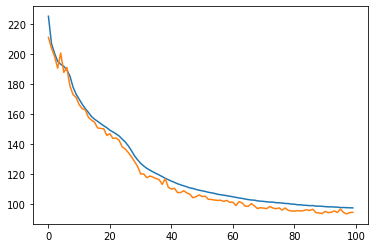

In [ ]:
print(_history.history)
plt.plot(_history.history['loss'])
plt.plot(_history.history['val_loss'])

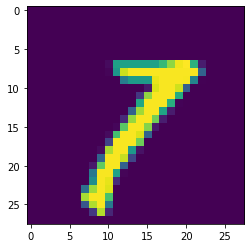

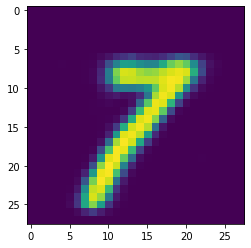

In [ ]:
randInt = np.random.randint(0,_xtest.shape[0])
plt.imshow(_xtest[randInt][...,0])
plt.show()
plt.imshow(tf.nn.sigmoid(vae(_xtest[randInt:randInt+1])).numpy()[0,...,0])
plt.show()

In [ ]:
vae.save('./vae', save_format='tf')

In [ ]:
vae.decoder.save('./decoder', save_format='tf')

In [ ]:
!zip -r vae.zip ./vae
!zip -r decoder.zip ./decoder

updating: vae/ (stored 0%)
updating: vae/assets/ (stored 0%)
updating: vae/saved_model.pb (deflated 89%)
updating: vae/variables/ (stored 0%)
updating: vae/variables/variables.index (deflated 70%)
updating: vae/variables/variables.data-00000-of-00001 (deflated 32%)
  adding: decoder/ (stored 0%)
  adding: decoder/saved_model.pb (deflated 90%)
  adding: decoder/variables/ (stored 0%)
  adding: decoder/variables/variables.index (deflated 53%)
  adding: decoder/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: decoder/assets/ (stored 0%)


In [ ]:
files.download('vae.zip')
files.download('decoder.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Download trained decoder

We will begin this tutorial here. Everything prior to this point is the training of a variational auto encoder which will allow us to build a decoder which can, given a random tensor of size 512, generate a handwritten number as in MNIST.

In [ ]:
!gdown https://drive.google.com/uc?id=1Qoj77Gs-P1uQW20o0N5JBQOpmiy4APTW
!unzip ./decoder.zip

Downloading...
From: https://drive.google.com/uc?id=1Qoj77Gs-P1uQW20o0N5JBQOpmiy4APTW
To: /content/decoder.zip
51.5MB [00:00, 241MB/s]
Archive:  ./decoder.zip
   creating: decoder/
  inflating: decoder/saved_model.pb  
   creating: decoder/variables/
  inflating: decoder/variables/variables.index  
  inflating: decoder/variables/variables.data-00000-of-00001  
   creating: decoder/assets/


In [ ]:
_m = tf.keras.models.load_model('./decoder')

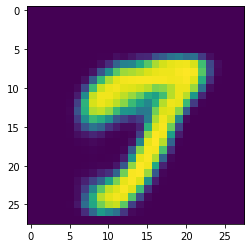

In [ ]:
plt.imshow(tf.nn.sigmoid(_m(tf.random.normal([1,512]))).numpy()[0,...,0])
plt.show()

## Convert model to TFJS and quantize

In [ ]:
!mkdir -p ./tfjs_model
!rm -rf ./tfjs_model/*
!tensorflowjs_converter --quantize_uint8=* ./decoder ./tfjs_model &>/dev/null
!du -sh ./tfjs_model

14M	./tfjs_model


## Keystore Upload

In the next cell, please select the keystores. 

In [ ]:
_uploaded = files.upload()
print(_uploaded.keys())
!mkdir -p ~/.dcp && mv /content/*.keystore ~/.dcp/

Saving default.keystore to default.keystore
Saving id.keystore to id.keystore
dict_keys(['default.keystore', 'id.keystore'])


## Upload model to DCP 

Make sure to rename the module and to change the package version down to 0.0.1


In [ ]:
!node /content/tfjs_util/bin/serializeModel.js -m ./tfjs_model/model.json -o mnist_vae_ex/tfjs_decoder.js -p 0.0.7 -d

2020-11-21 18:00:03.597544: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-11-21 18:00:03.608776: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-11-21 18:00:03.608962: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3052e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-21 18:00:03.608990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Module published at :  mnist_vae_ex/tfjs_decoder.js
Done!


In [ ]:
SCHEDULER  = 'https://demo-scheduler.distributed.computer'  #@param ['https://demo-scheduler.distributed.computer', "https://scheduler.distributed.computer"]
numImagesPerWorker = 31 #@param {type:"slider", min:10, max:100, step:2}
numworkers = 100 #@param {type:"slider", min:10, max:100, step:1 }

npm.install( 'dcp-client' )


> keccak@3.0.1 install /content/node_modules/keccak
> node-gyp-build || exit 0


> secp256k1@4.0.2 install /content/node_modules/secp256k1
> node-gyp-build || exit 0


> dcp-worker@1.1.3 postinstall /content/node_modules/dcp-worker
> node generate-native-env-script

Wrote native evaluator env file to native-evaluator-env.js
+ dcp-client@3.2.6
added 548 packages from 427 contributors and audited 728 packages in 16.476s

21 packages are looking for funding
run `npm fund` for details

found 0 vulnerabilities



# Perform Distributed Inference

In [ ]:
%%node

process.argv.push('--scheduler', SCHEDULER)
require('dcp-client').initSync(process.argv)
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');

var accountKeystore;
var identityKeystore;

(async function(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    wallet.addId(identityKeystore);
    accountKeystore = await dcpCli.getAccountKeystore();
    console.log("Keystores loaded!");
})();

Keystores loaded!


In [ ]:
%%node
var results=[];

(async function(){
    let batch = numImagesPerWorker;
    let numCompute = [...Array(numworkers).keys()];
    //#[ 1, 2, 3, 4, 5] //worker 1 would get 1, worker 2 would get 2, wou
    //#Main worker function which computes some handwritten digit batch number of times
    let job = compute.for(numCompute,async function(id, batch){
        progress();
        const tf = require('tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        progress();
        const { getModel } = require('tfjs_decoder');
        progress();
        let model = await getModel();
        let mean = (Math.random() * 10) - 5;
        let std  = (Math.random() * 5);
        let input_tensor = tf.randomNormal([batch, 512], mean, std, dtype='float32');
        progress();
        let out = model.predict(input_tensor);
        progress();
        out = tf.sigmoid(out); //#[ 0-1 ]
        let outTA = out.dataSync();
        progress();
        out.dispose();
        input_tensor.dispose();
        progress();
        return Array.from(outTA);

    }, [batch]); //#[ model.weights ]  #worker 1 would get model.weighst, worker 2 would get model.weights
    
    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    job.on('result', (value)=>{

        results = results.concat(value.result);
    });

    job.public.name='mnist-vae';
    job.requires('aistensorflow/tfjs');
    job.requires('mnist_vae/tfjs_decoder');

    //job.requirements.environment.offscreenCanvas = true;
    console.log("Launching Job");
    try{
        await job.exec(compute.marketValue, accountKeystore);
    }catch(err){
        console.log(err);
        await job.cancel();
        console.log("Job cancelled out");
    }
    results = Float32Array.from(results)

    results = buildDataArray(results, shape=[batch*numCompute.length,28,28, 1])
    console.log("Done executing job");
})()

Launching Job
Job accepted...
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 0, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 1, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 2, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 3, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 4, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 5, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 6, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 7, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 8, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 9, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK',
total: 100,
distributed: 10,
comp

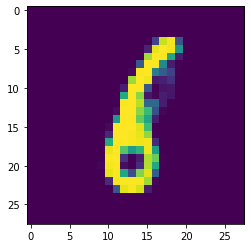

In [ ]:
plt.imshow( results[ np.random.randint(0, results.shape[0] )][...,0] )
plt.show()

In [ ]:
print(results.shape)

(3100, 28, 28, 1)
